In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [5]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utilities.utils import *

from src.plotting import Plotter
from src.gl_solver import GLSolver
from src.parameters_init import ParametersInit
from src.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
Nx=8
Ny=8

Lx=50 
Ly=50

T_end = 1
dt = 0.005

N_ITERATIONS = int(T_end / dt)

In [7]:
A_norm, A_original, mem_rate, myu_original = compute_A_norm(
    Nx=Nx, 
    Ny=Ny, 
    input_to_defect_ratio=2*2, 
    mean=5.4, 
    std_deviation=0.8, 
    time_period=25, 
    Lx=Lx, 
    Ly=Ly, 
    dt=dt, 
    T_End=T_end, 
    parallel_runs=1, 
    input_scale=0.75, 
    mem_coef=1, 
    time_period_parameter=100, 
    _mean=2.7, 
    std_deviation_run_computation=0.8,
    input_myu=None
)

100%|██████████| 200/200 [00:00<00:00, 3508.85it/s]

Unique Myus count	 32
Max value of myu:	 32.07538562256453
Min value of myu:	 5.200142928123542
Unique values: [5.200142928123542, 6.776802194019763, 9.832467626059293, 9.930348765548707, 9.93636614540726, 11.087163442089999, 11.532539027064008, 11.689208102837993, 12.126889602680144, 14.066457057829007, 15.41456415322822, 15.55181349162192, 15.580964078459347, 15.89050948486973, 15.902039798447916, 17.308316939903445, 17.817916265645763, 17.860146414375606, 18.022473614692963, 18.70875764511521, 20.836401795971625, 20.876899548344703, 21.429794823097982, 21.454250807145073, 22.844510759983958, 23.47469382631318, 23.795643877441844, 24.251657418524097, 24.845350271280978, 26.363587123665948, 27.24339625394467, 32.07538562256453]
Counts:		 [400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400
 400 400 400 400 400 400 400 400 400 400 400 400 400 400]
A.shape=(1, 200, 8, 8),
Myu.shape=(1, 200, 8, 8),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


In [8]:
def output_plot(data, mem_rat, save_fig=False, file_name="A_in_norm_80%04d.png"):
    fig = plt.figure(1, figsize=(6.5, 6.5))
    for index in tqdm(range(mem_rat)):
        if index % 2 == 0:
            plt.clf()
            plt.imshow(data[index, :, :], origin='lower', vmax=0.9*np.max(data))
            plt.colorbar()
            if save_fig:
                filename = file_name % (index/2)
                plt.savefig(filename)

100%|██████████| 200/200 [00:06<00:00, 29.26it/s]


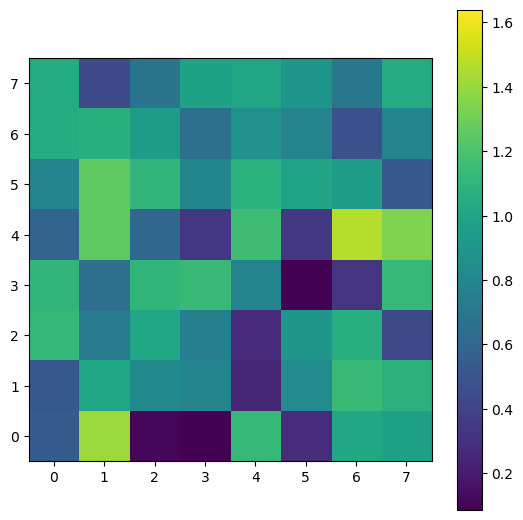

In [9]:
output_plot(A_norm, mem_rate)

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

In [10]:
snn_layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 1]

x = np.linspace(0, Lx, Nx).flatten()[:, None]
y = np.linspace(0, Ly, Ny).flatten()[:, None]
t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

Exact = A_original.squeeze(0)

X, T, Y = np.meshgrid(x, t, y)

X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()
u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

In [11]:
X_star.shape, u_star.shape

((12800, 3), (12800, 2))

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [12]:
class LOSS:
  def __init__(self, x, y, t, verbose = 0):
      self.msef = nn.MSELoss()
      self.MSE = []
      self.F = []
      self.FMSE = []
      self.verbose = verbose
      self.x = x
      self.y = y
      self.t = t

  def load(self,y_pred,y_real):
      self.y_pred = y_pred
      self.y_real = y_real

    
  def plot(self):
    fig, [upper,lower] = plt.subplots(nrows=2)
    upper.plot(self.MSE)
    upper.legend("MSE")
    upper.set_title("MSE")
    upper.set_yscale('log')
    lower.plot(self.FMSE)
    lower.legend("FMSE")
    lower.set_title("FMSE")
    lower.set_yscale('log')
    plt.show()

  def mse(self):
      loss = self.msef(self.y_pred,self.y_real)
      if(self.verbose):
        print(f"MSELOSS: {loss}")
      self.MSE.append(loss.cpu().detach().numpy())
      return loss

  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss

  def __radd__(self, other):
    if other == 0:
        return self
    else:
        return self.__add__(other)  
  def __add__(self, L):
    l = LOSS(self.x,self.y,self.t, verbose = self.verbose)
    if "y_pred" in dir(self):
        l.load(self.y_pred, self.y_real)
    if "y_pred" in dir(L):
        l.load(L.y_pred, L.y_real)
    l.MSE = self.MSE + L.MSE
    l.FMSE = self.FMSE + L.FMSE
    l.F = self.F + L.F
    return l

  def net_f(self, myu, verbose = 0):
        torch.autograd.set_detect_anomaly(True)
        x,y,t = self.x, self.y, self.t

        ru = self.y_pred[:,0]
        iu = self.y_pred[:,1]

        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j).view(200, 4, 4)
        u_t = (ru_t + iu_t * 1j).view(200, 4, 4)
        u_xx =( ru_xx + iu_xx *1j).view(200, 4, 4)
        u_yy = (ru_yy + iu_yy *1j).view(200, 4, 4)

        if(verbose):
            print('u_t:',u_t)
            print('u:',u)
            print('u_xx:',u_xx)
            print('u_yy:',u_yy)
            
        f = u_t - myu*u - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u
        free_memory(u, u_t, u_xx, u_yy)

        return f
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [13]:
class VAHANNET(nn.Module):
    def __init__(self, layers):
        super(VAHANNET, self).__init__()

        self._depth = len(layers) - 1
        self._activation_function = torch.nn.Softplus
        layers_list = list()

        for i in range(self._depth - 1):
            layers_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1], dtype = torch.float64)))
            layers_list.append(('activation_%d' % i, self._activation_function()))

        layers_list.append(('layer_%d' % (self._depth - 1), torch.nn.Linear(layers[-2], layers[-1], dtype = torch.float64)))
        layerDict = OrderedDict(layers_list)
        self._nn = torch.nn.Sequential(layerDict)

        myu_tensor = torch.randn(2, 4, dtype=torch.float64).to(device)
        transformed_myu_tensor = transform_and_stack(myu_tensor, 4, 25)
        myu = nn.Parameter(transformed_myu_tensor).to(device)
        self.myu = myu
        self.register_parameter('myu', self.myu)

        self.optimizer = torch.optim.Adam( params = self._nn.parameters(), lr=0.01 )    
        self.myuoptimizer = torch.optim.SGD(params =[self.myu], lr=20 )

    def predict(self, x):
        self._nn.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self._nn(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j

    def forward(self, x):
        if type(x) is not torch.Tensor:
          x = torch.tensor(x, dtype = torch.float64).to(device)
        return self._nn(x)


    def train(self, x, y, epochs=100, verbose = 0, mode = 1,speed = 0):
        x = torch.tensor(x, dtype = torch.float64, requires_grad=True).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)

        self.optimizer.zero_grad()
        tuplex = tuple(x.T)
        L = LOSS(*tuplex, verbose= verbose)
        x = torch.stack(tuplex).T

        for _ in tqdm(range(epochs)):

          L.load(self.forward(x),y)
          if(mode == 1 or (mode == 3 and not _%2)):
              if not speed: L.fmse(self.myu)
              L.mse().backward()
          if(mode == 2 or (mode == 3 and _%2)):              
              if not speed: L.mse()
              L.fmse(self.myu).backward()          

          self.optimizer.step()
          self._nn.zero_grad()

        return L  
        
    
    def myutrain(self,x, verbose = 0, zero_grad = True):
        x = torch.tensor(x, dtype = torch.float64, requires_grad=True).to(device)
        
        if zero_grad:
            self.myuoptimizer.zero_grad()
            
        tuplex = tuple(x.T)
        L = LOSS(*tuplex, verbose= verbose)
        x = torch.stack(tuplex).T

        L.load(self.forward(x),1)
        L.fmse(self.myu).backward()

        self.myuoptimizer.step()
        self._nn.zero_grad()

        return L
        
    def fastmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        from torch.utils.data import DataLoader

        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        lossf = nn.MSELoss()
        L = []
        
        import math
        batchiter = (epochs * batch_size)  // x.size()[0]
        epochs =  batchiter * math.ceil(x.size()[0] / batch_size)
        
        pbar = tqdm(total=epochs)
        for _ in range(batchiter):
            for i, tmp in enumerate(dataloader):
                (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                X = torch.stack((tmpx,tmpy,tmpt)).T
                U = torch.stack((tmpu_real, tmpu_img)).T

                y_pred = self.forward(X)
                loss = lossf(y_pred,U)
                L.append(loss.cpu().detach().numpy())
                loss.backward()
                self.optimizer.step()
                self._nn.zero_grad()
                # Update the progress bar
                pbar.update(1)

        # Close the progress bar
        pbar.close()                

        return L         

    
    def fastmsetrain(self, x, y, epochs=100):
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        
        self.optimizer.zero_grad()
        lossf = nn.MSELoss()
        L = []
        
        for _ in tqdm(range(epochs)):
            y_pred = self.forward(x)
            loss = lossf(y_pred,y)
            L.append(loss.cpu().detach().numpy())
            loss.backward()
            self.optimizer.step()
            self._nn.zero_grad()       

        return L     

In [14]:
import torch
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(False)
torch.manual_seed(1)
net = VAHANNET([3,128,256,512,256,128,2]).to(device)
net.myu = torch.nn.Parameter(torch.tensor(myu_original, dtype = torch.float64).to(device))
L = net.fastmsebatchtrain(x = X_star, y = u_star, batch_size = 256, epochs = 14000)

100%|██████████| 14000/14000 [01:38<00:00, 141.60it/s]


In [15]:
Ll = net.fastmsetrain(x = X_star, y = u_star, epochs = 1000)

100%|██████████| 1000/1000 [03:56<00:00,  4.22it/s]


In [16]:
l2 = net.train(x = X_star, y = u_star, mode = 1, speed = 0)

  0%|          | 0/100 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 3.00 GiB total capacity; 2.53 GiB already allocated; 0 bytes free; 2.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
L

[array(5.64698869),
 array(3111.5251246),
 array(13.27132887),
 array(19.4169687),
 array(7.83719696),
 array(6.43368144),
 array(7.12675344),
 array(6.4394353),
 array(5.6610617),
 array(6.0001953),
 array(7.64118581),
 array(5.73360803),
 array(6.05583941),
 array(13.9157143),
 array(10.31720195),
 array(9.84368923),
 array(9.10772676),
 array(6.62656899),
 array(5.84550791),
 array(9.26364556),
 array(5.51655885),
 array(5.44676333),
 array(5.635687),
 array(5.98432443),
 array(5.81015936),
 array(6.07095915),
 array(5.67160511),
 array(5.88507496),
 array(6.07781093),
 array(5.90235497),
 array(5.59639087),
 array(5.82136385),
 array(5.81794373),
 array(5.94298776),
 array(5.69297858),
 array(5.78265488),
 array(6.05210798),
 array(5.69470909),
 array(5.79268936),
 array(5.46857803),
 array(5.48581012),
 array(5.82504257),
 array(5.83593595),
 array(5.90471891),
 array(6.28645118),
 array(5.43615588),
 array(5.74704575),
 array(5.38975724),
 array(5.71766039),
 array(6.33305573),
 

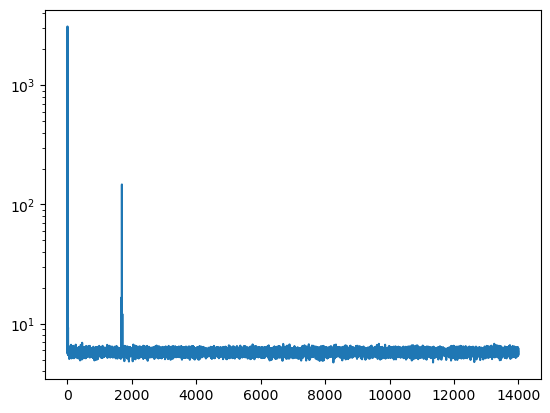

In [17]:
plt.plot(L)
plt.yscale('log')

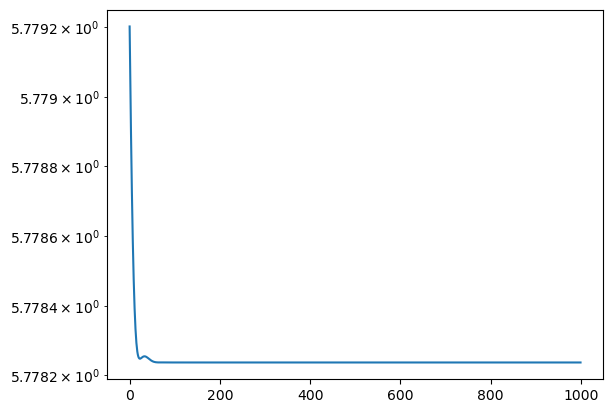

In [18]:
plt.plot(Ll)
plt.yscale('log')

In [ ]:
l2.plot()

In [ ]:
path="combo_test"
create_gifs(
    memory_rate=mem_rate,
    u_pred=net.predict(X_star).reshape(1,200,4,4),
    original=A_original,
    save=True,
    path_for_gif=path+".gif",
    duration=500,
    title=" "
)
Image(filename=path+".gif")